# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
tf_idf_matrix=TfidfVectorizer()
final_tf_idf = tf_idf_matrix.fit_transform(["hi how are how you","how is going on"])
# print(final_tf_idf.todense())

dictionary = dict(zip(tf_idf_matrix.get_feature_names(), list(tf_idf_matrix.idf_)))
print("idf value of 'you' as per tf_idf_matrix.idf_:",dictionary['you'])
feature_tfidf=tf_idf_matrix.get_feature_names()
print(feature_tfidf)
print('number of features in tf idf=',len(feature_tfidf))
print(final_tf_idf[0,feature_tfidf.index('you')])
print(dictionary['you']*1)
print(np.log((1+2)/(1+1))+1)

idf value of 'you' as per tf_idf_matrix.idf_: 1.4054651081081644
['are', 'going', 'hi', 'how', 'is', 'on', 'you']
number of features in tf idf= 7
0.4461008073765536
1.4054651081081644
1.4054651081081644


In [4]:

# using the SQLite Table to read data.
con = sqlite3.connect('/Users/amit.peshwani/Downloads/amazon-fine-food-reviews/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [13]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'from', 'shan', "should've", 'ain', 'my', "aren't", 'wasn', 'while', 'myself', 'do', 'them', 'own', 'ours', 'does', 'hadn', 'nor', 'it', 'these', 'who', 'yourselves', 'your', 'o', 'here', 'that', 'further', 'or', 've', 'ourselves', 'all', 'through', 'hers', 'than', 'll', "she's", "you've", 'most', 'there', 'having', 'off', "shan't", 'yourself', 'after', 'in', 'until', 'each', 'if', 'can', 'whom', "mightn't", 'wouldn', 'shouldn', 'because', 'any', "isn't", 'doing', 'again', "haven't", 'her', 'the', 'no', 'hasn', 'what', "weren't", "you'd", 'very', 'couldn', 'and', 'only', 'under', 'when', 'weren', 'she', 'his', 'by', 'below', 'am', 're', 'into', 'as', 'at', 'where', "wouldn't", 'itself', 'theirs', 'of', 's', 'a', 'has', 'above', 'haven', 'is', 'so', 'to', 'same', 'were', 'on', 'then', 'he', 'd', 'down', 'between', 'had', 'm', 'just', 'during', 'against', 'aren', 'now', 'needn', "couldn't", 'ma', 'been', 'yours', "won't", 'with', 'didn', 'some', "needn't", 'mightn', 'him', 'out', 'both'

In [ ]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [14]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# [7.2.2] Bag of Words (BoW)

In [15]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 71624)
the number of unique words  71624


## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [16]:
with open('positive_words.pkl', 'rb') as f:
    all_positive_words = pickle.load(f)
with open('negitive_words.pkl', 'rb') as f:
    all_negative_words = pickle.load(f)
    
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


#### Now we will take 1k +ve reviews and 1k -ve reviews

<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [115]:
final_1k_pos = final[final['Score'] == 1].sample(n = 1000)
final_1k_neg = final[final['Score'] == 0].sample(n = 1000)
print (final_1k_pos.shape)
print (final_1k_pos.shape)
final_2k = pd.concat([final_1k_pos , final_1k_neg])
print (final_2k.shape)
score_2k = final_2k['Score']
print (score_2k.shape)

(1000, 12)
(1000, 12)
(2000, 12)
(2000,)


#### Now text will be converted to vectors using bigram

In [116]:
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final_2k['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 66507)
the number of unique words including both unigrams and bigrams  66507


#### Now standardize the obtained vector using sklearn.preprocessing.StandardScaler

In [117]:
#This scaler can also be applied to sparse CSR or CSC matrices by passing 
#with_mean=False to avoid breaking the sparsity structure of the data.

from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
print (std_data.shape)
print (type(std_data))

(2000, 66507)
<class 'scipy.sparse.csr.csr_matrix'>


/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/envs/yolo/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### Now converting sparse to dense for t-SNE as it takes dense matrix

In [118]:
std_data = std_data.todense()
print (std_data.shape)
print (type(std_data))

(2000, 66507)
<class 'numpy.matrixlib.defmatrix.matrix'>


#### Now t-SNE on standaradized vector using multicore t-SNE 
https://github.com/DmitryUlyanov/Multicore-TSNE

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


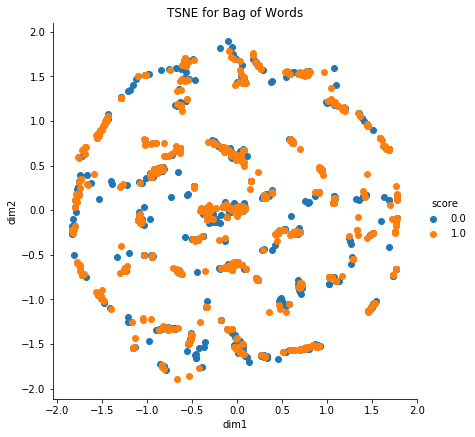

In [119]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,n_iter = 5000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


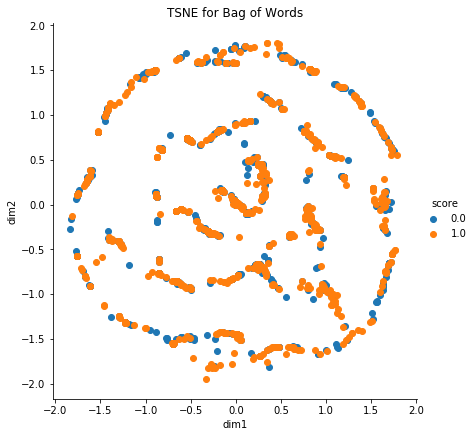

In [21]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,n_iter = 10000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


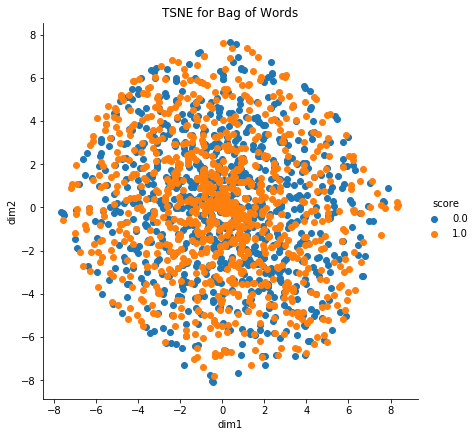

In [26]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity = 5 ,n_iter = 1000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


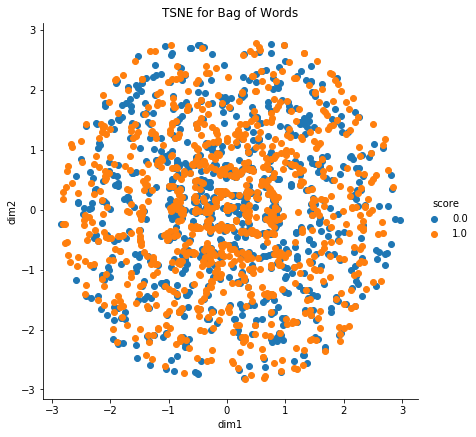

In [27]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity = 5 ,n_iter = 5000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


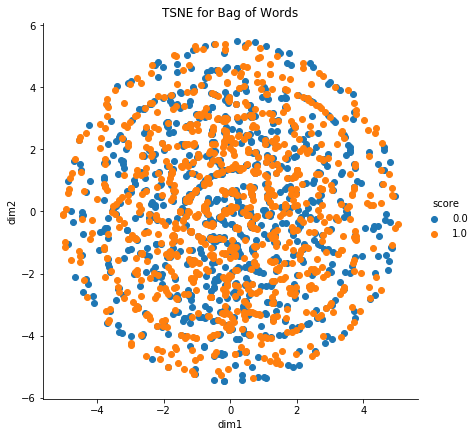

In [28]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity = 5 ,n_iter = 10000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


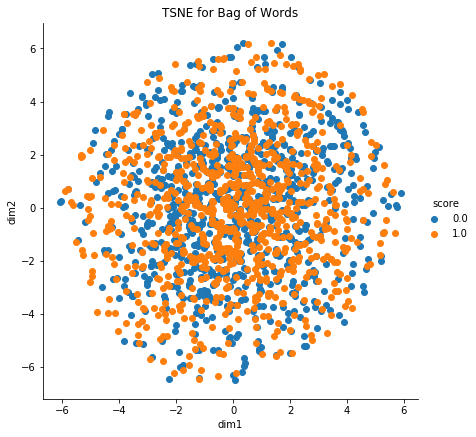

In [29]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity = 10 ,n_iter = 1000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


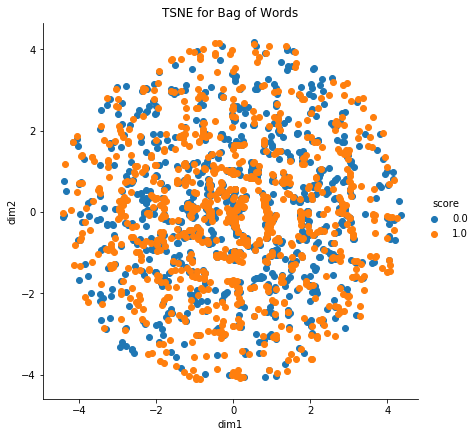

In [30]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity = 10 ,n_iter = 5000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


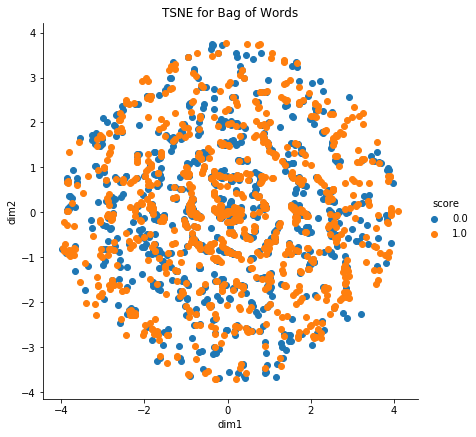

In [31]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity = 10 ,n_iter = 10000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


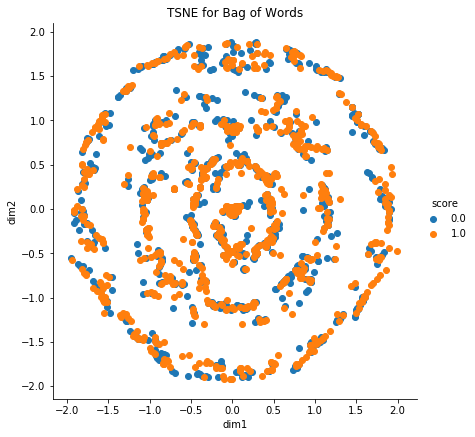

In [33]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity = 15 ,n_iter = 1000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


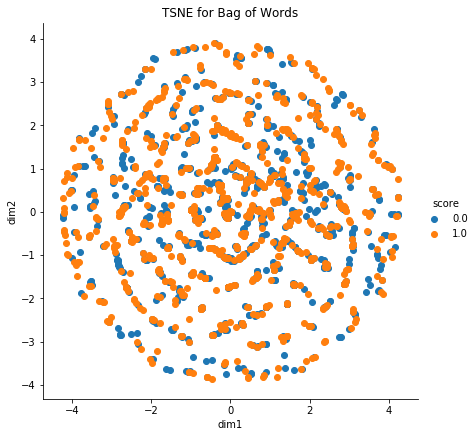

In [34]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity = 15 ,n_iter = 5000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


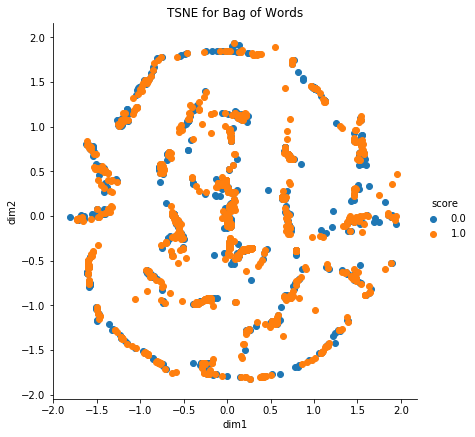

In [35]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity = 20 ,n_iter = 1000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

### Observation 

- By changing perplexity and number of iteration values , t-SNE was not able to seperate +ve and -ve values of vectors (Bag of Words)

In [25]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 2923725)
the number of unique words including both unigrams and bigrams  2923725


# [7.2.5] TF-IDF

#### Converting 1k +ve and 1k -ve to vector using tf-idf

In [121]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_2k['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 66507)
the number of unique words including both unigrams and bigrams  66507


#### standardizing the obtained vector using sklearn.preprocessing.StandardScaler

In [122]:
from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_tf_idf)
print (std_data.shape)
print (type(std_data))

(2000, 66507)
<class 'scipy.sparse.csr.csr_matrix'>


#### converting sparse to dense for t-SNE as it takes dense matrix

In [123]:
std_data = std_data.todense()
print (std_data.shape)
print (type(std_data))

(2000, 66507)
<class 'numpy.matrixlib.defmatrix.matrix'>


#### t-SNE on tf-idf

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


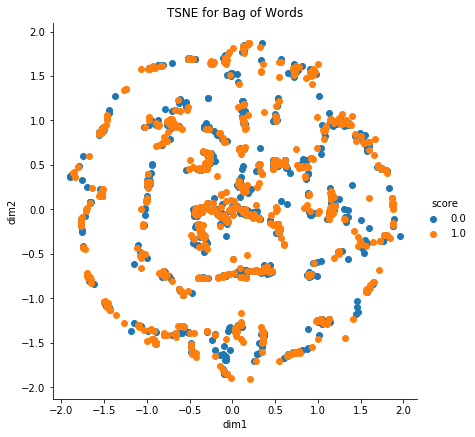

In [82]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,n_iter = 5000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


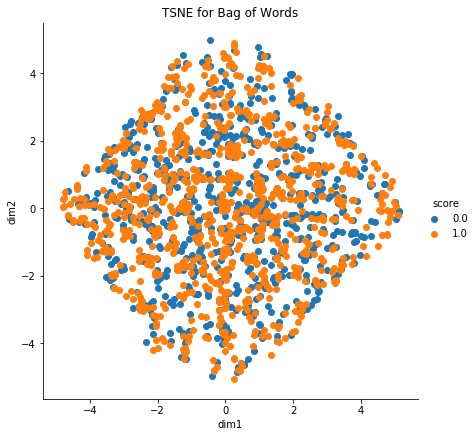

In [42]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity=5 ,n_iter = 1000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


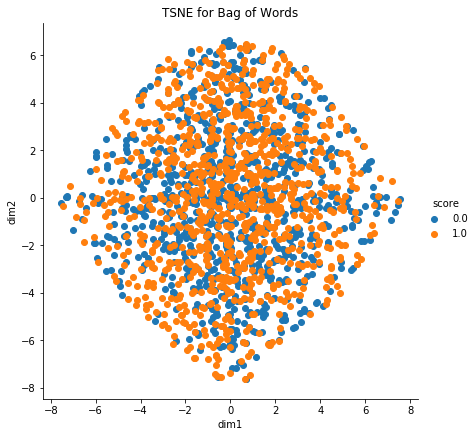

In [43]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity=5 ,n_iter = 5000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


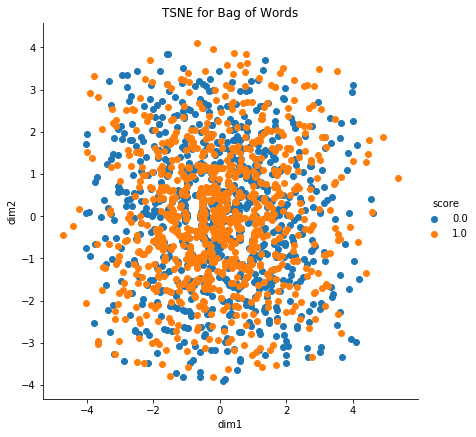

In [44]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity=10 ,n_iter = 1000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


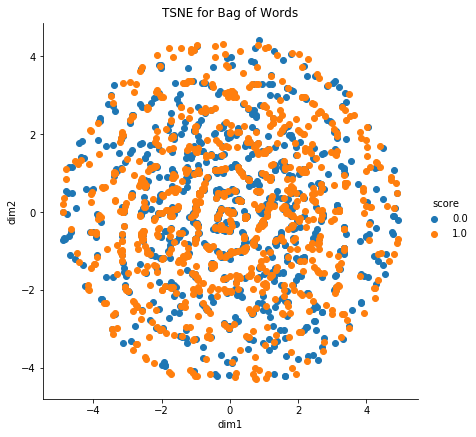

In [45]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity=10 ,n_iter = 2500).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


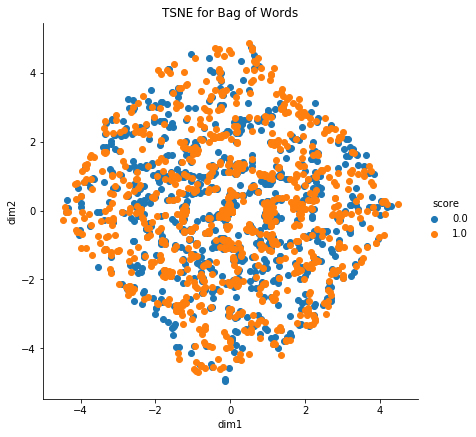

In [46]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity=10 ,n_iter = 5000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


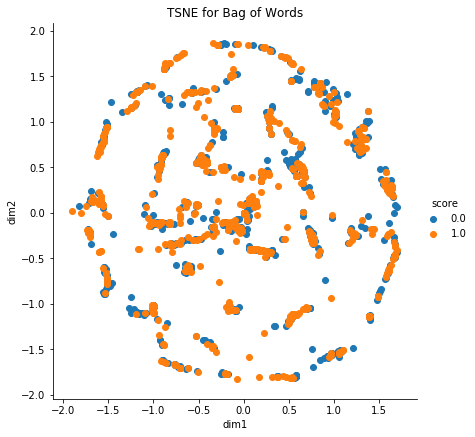

In [48]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity=20 ,n_iter = 1000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


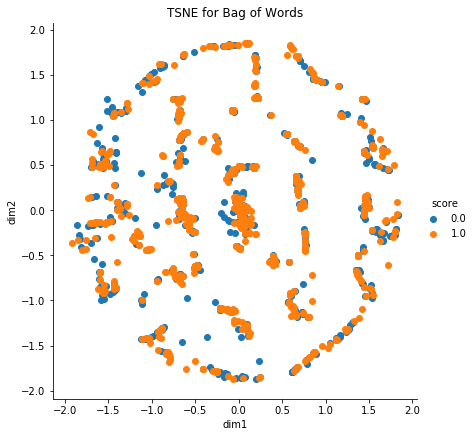

In [49]:
from MulticoreTSNE import MulticoreTSNE as TSNE

# from sklearn.manifold import TSNE

# model = TSNE(n_components=2, random_state=0, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,perplexity=20 ,n_iter = 5000).fit_transform(std_data)
# tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


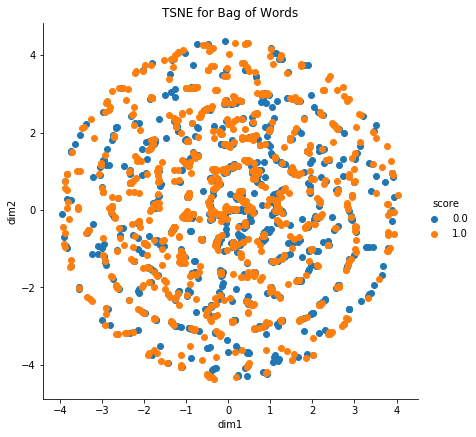

In [52]:
# from sklearn.decomposition import TruncatedSVD

tsne_data = TSNE(n_components=2 , random_state=0 ,perplexity = 15 ,n_iter = 5000).fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

### Observation :

- Changing the values of perplexity and number of iterations , t-SNE  not able to seperate +ve and -ve review

In [39]:
features = tf_idf_vect.get_feature_names()

print("some sample features(unique words in the corpus)",features[1000:1005])

some sample features(unique words in the corpus) ['alimentum lot', 'aliv', 'aliv came', 'aliv tasti', 'aliv thank']


In [40]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [41]:
top_tfidf

,feature,tfidf
0,delici tea,0.382710
1,qualiti amount,0.382710
2,offer great,0.382710
3,tea offer,0.363088
4,price qualiti,0.338367
5,great price,0.271279
6,offer,0.230972
7,amount,0.208622
8,delici,0.192911
9,qualiti,0.187908


# [7.2.6] Word2Vec

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
# is_your_ram_gt_16g=False
# want_to_read_sub_set_of_google_w2v = True
# want_to_read_whole_google_w2v = True
# if not is_your_ram_gt_16g:
#     if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
#         with open('google_w2v_for_amazon.pkl', 'rb') as f:
#             # model is dict object, you can directly access any word vector using model[word]
#             model = pickle.load(f)
# else:
#     if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [54]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final_2k['CleanedText'].values:
    list_of_sent.append(sent.split())

In [55]:
print(final_2k['CleanedText'].values[1])
print("*****************************************************************")
print(list_of_sent[1])

excel custom servic sent inquiri via email respond quick via email follow phone call well item receiv faster expect love order paella com
*****************************************************************
['excel', 'custom', 'servic', 'sent', 'inquiri', 'via', 'email', 'respond', 'quick', 'via', 'email', 'follow', 'phone', 'call', 'well', 'item', 'receiv', 'faster', 'expect', 'love', 'order', 'paella', 'com']


In [56]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=2)

In [57]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2033
sample words  ['bought', 'varieti', 'box', 'may', 'gluten', 'free', 'amaz', 'great', 'tast', 'best', 'energi', 'bar', 'far', 'keep', 'stock', 'tri', 'travel', 'safe', 'food', 'eat', 'attack', 'definit', 'shop', 'list', 'excel', 'custom', 'servic', 'sent', 'via', 'email', 'respond', 'quick', 'follow', 'call', 'well', 'item', 'receiv', 'faster', 'expect', 'love', 'order', 'com', 'awesom', 'realli', 'good', 'filler', 'took', 'place', 'complet', 'meal']


In [58]:
w2v_model.wv.most_similar('tasti')

[('low', 0.999825119972229),
 ('salt', 0.9998155832290649),
 ('look', 0.9998072981834412),
 ('sinc', 0.9998034238815308),
 ('extra', 0.9998009204864502),
 ('cook', 0.999792218208313),
 ('color', 0.9997920393943787),
 ('new', 0.9997814297676086),
 ('notic', 0.9997812509536743),
 ('enough', 0.999779462814331)]

In [59]:
w2v_model.wv.most_similar('like')

[('doesnt', 0.9997727870941162),
 ('bad', 0.9997014999389648),
 ('smell', 0.9996967315673828),
 ('textur', 0.9996898174285889),
 ('good', 0.9996723532676697),
 ('strong', 0.9996720552444458),
 ('sweet', 0.9996694326400757),
 ('real', 0.9996618628501892),
 ('bitter', 0.9996576309204102),
 ('appl', 0.999645471572876)]

# [7.2.7] Avg W2V, TFIDF-W2V

In [60]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
print(type(sent_vectors))
print (sent_vectors[0])


100%|██████████| 2000/2000 [00:01<00:00, 1674.87it/s]

2000
50
<class 'list'>
[-0.09092447 -0.30850762  0.19538195 -0.28282469 -0.17131867  0.07351444
 -0.68288887  0.27948577 -0.14885489 -0.17296862  0.55449037  0.13868567
  0.22548182  0.7010735  -0.3561813  -0.14520209 -0.22104246 -0.47660441
  0.20227039  0.36779225  0.29360377  0.09782314  0.27504087 -0.07690841
 -0.62503738 -0.17513644 -0.42441342 -0.15996302  0.39790094 -0.0129716
  0.10657353  0.29020216  0.59342896  0.25510718  0.28291153  0.31899055
 -0.76576096  0.21489291  0.77388509  0.18952436 -0.10106333 -0.19906067
  0.43806524  0.22649385 -0.24869987  0.40881708 -0.48042712 -0.25161651
 -0.33363413  0.55001323]


/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


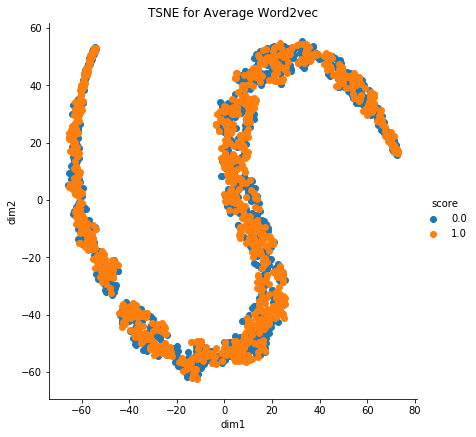

In [89]:

# from MulticoreTSNE import MulticoreTSNE as TSNE
# tsne_data = TSNE(n_jobs=2 , n_components=2 , random_state=0 ,n_iter = 5000).fit_transform(sent_vectors)




# tsne_data = np.vstack((tsne_data.T, score_2k)).T
# tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
# plt.title("TSNE for Bag of Words")
# plt.show()


from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)

tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Average Word2vec")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


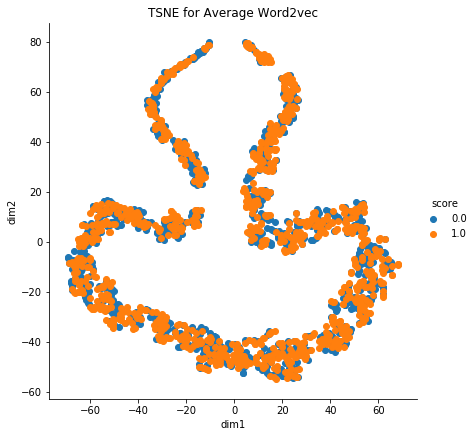

In [63]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 15, n_iter = 1000)

tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Average Word2vec")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


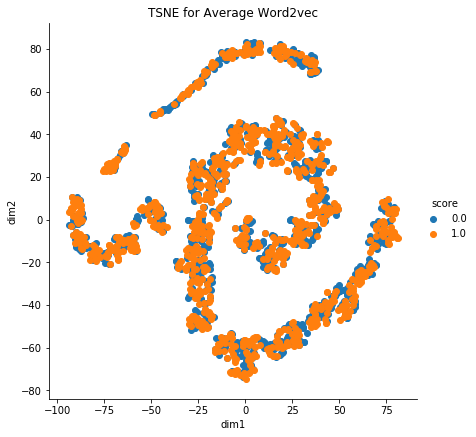

In [62]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 10, n_iter = 1000)

tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Average Word2vec")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


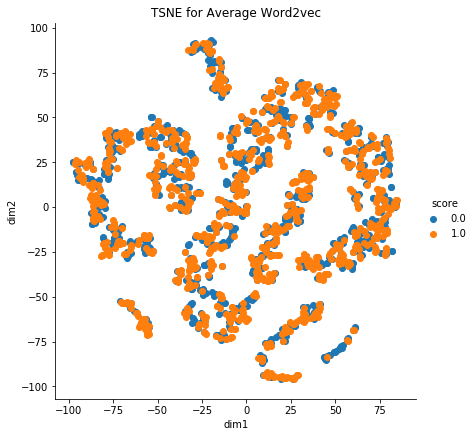

In [64]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 5, n_iter = 1000)

tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Average Word2vec")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


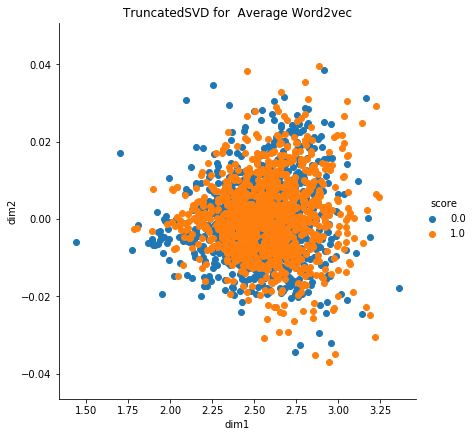

In [86]:
from sklearn.decomposition import TruncatedSVD

tsne_data = TruncatedSVD(n_components=2 , random_state=0 ,n_iter = 500).fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TruncatedSVD for  Average Word2vec")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


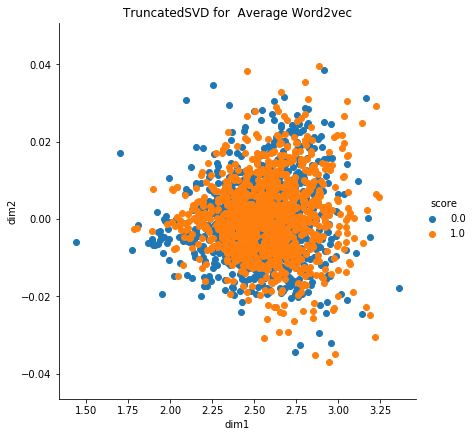

In [87]:
from sklearn.decomposition import TruncatedSVD

tsne_data = TruncatedSVD(n_components=2 , random_state=0 ,n_iter = 1000).fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TruncatedSVD for  Average Word2vec")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


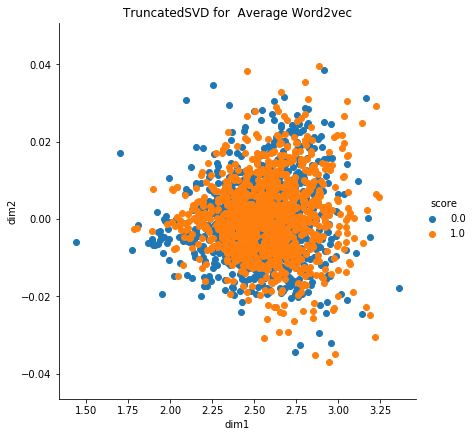

In [88]:
from sklearn.decomposition import TruncatedSVD

tsne_data = TruncatedSVD(n_components=2 , random_state=0 ,n_iter = 5000).fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TruncatedSVD for  Average Word2vec")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


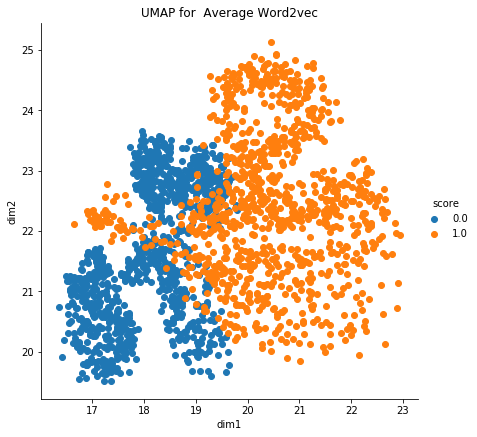

In [69]:
# from sklearn.decomposition import TruncatedSVD
import umap
tsne_data = umap.UMAP().fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("UMAP for  Average Word2vec")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


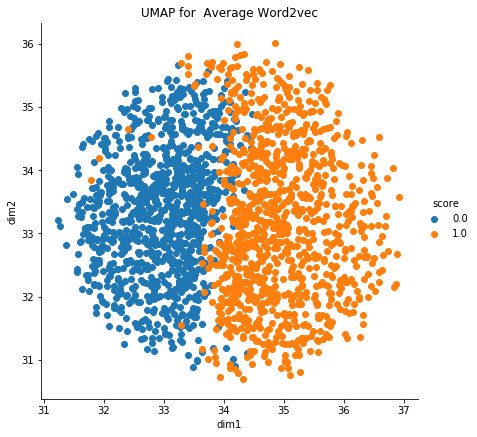

In [114]:

# from sklearn.decomposition import TruncatedSVD
import umap
tsne_data = umap.UMAP(n_neighbors=50, min_dist=0.3).fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("UMAP for  Average Word2vec")
plt.show()

### Observation:

- t-SNE and TruncatedSVD was not able to seperate +ve and -ve reviews(Avg Word2Vec).
- An alternate method called UMAP , was able to seperate +ve and -ve reviews .

In [94]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_2k['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# print (dictionary)

In [95]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
# print (tfidf_sent_vectors)
print (type(tfidf_sent_vectors))

100%|██████████| 2000/2000 [00:01<00:00, 1293.96it/s]

<class 'list'>


/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


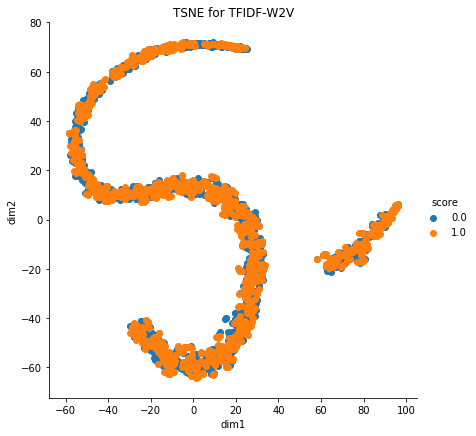

In [96]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,  n_iter = 5000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))


sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TFIDF-W2V")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


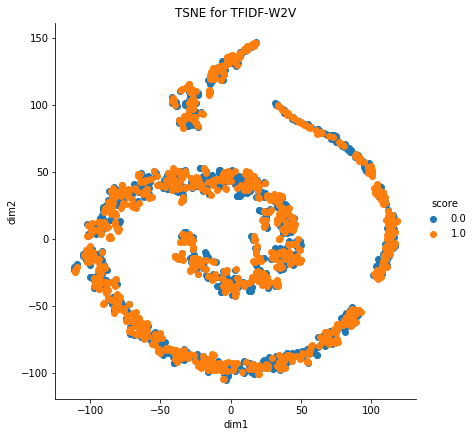

In [98]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=10 , n_iter = 5000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))


sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TFIDF-W2V")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


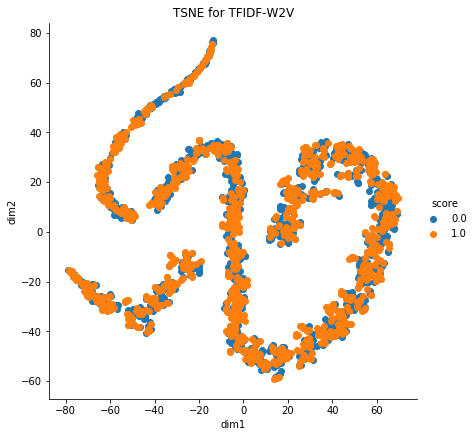

In [99]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=15 ,n_iter = 1000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))


sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TFIDF-W2V")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


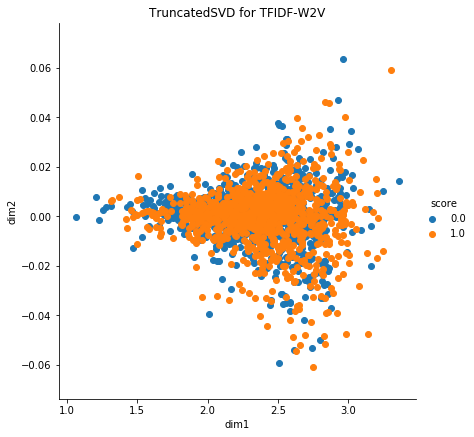

In [101]:
from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components=2, random_state=0,  n_iter = 10)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))


sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TruncatedSVD for TFIDF-W2V")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


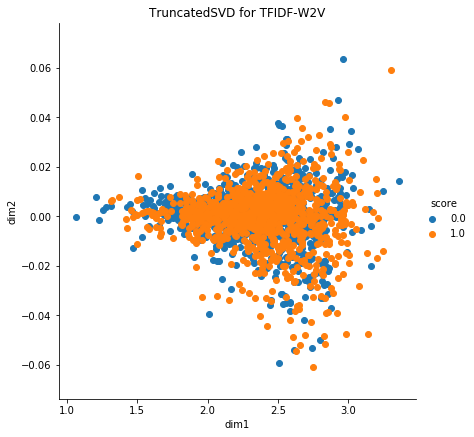

In [103]:
from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components=2, random_state=0,  n_iter = 1000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))


sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TruncatedSVD for TFIDF-W2V")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


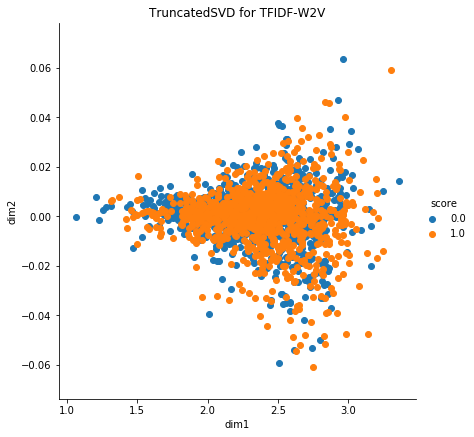

In [104]:
from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components=2, random_state=0,  n_iter = 5000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))


sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TruncatedSVD for TFIDF-W2V")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


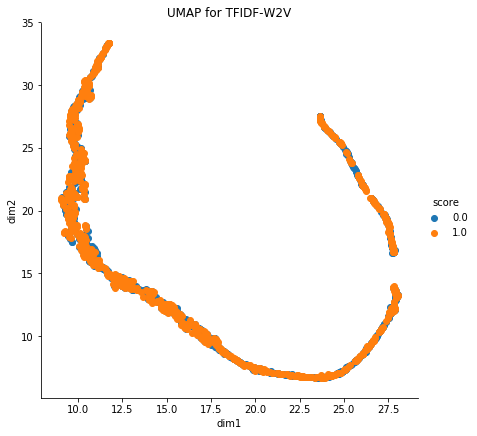

In [106]:
import umap
tsne_data = umap.UMAP().fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("UMAP for TFIDF-W2V")
plt.show()

/anaconda3/envs/yolo/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


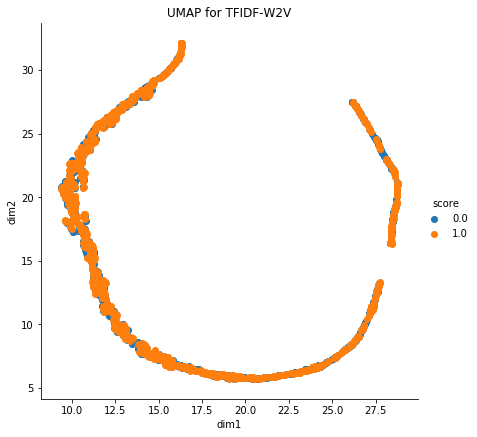

In [110]:
import umap
tsne_data = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("UMAP for TFIDF-W2V")
plt.show()

### Observation :

- t-SNE , TruncatedSVD and UMAP were not able to seperate +ve and -ve reviews (TFIDF-W2V)

## Conclusion:

- t-SNE was not able to seperate +ve and -ve reviews in any case . 
- So have to find some other alternate solution for seperativng reviews . 
- TruncatedSVD is faster than t-SNE and is better also in seperating .
- Tried a new method UMAP which was much faster than other methods and was able to seperate reviews in Average W2V .